<a href="https://colab.research.google.com/github/itinasharma/DeepLearning/blob/main/mtl_x2_x3_pytorch_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

APPROACH 1: Deep Shared Backbone + Simple Heads
Epoch    0 | Total=6.399035 | x²=3.142140 | x³=9.655931
Epoch  400 | Total=0.017550 | x²=0.001856 | x³=0.033244
Epoch  800 | Total=0.001991 | x²=0.000152 | x³=0.003830
Epoch 1200 | Total=0.000555 | x²=0.000049 | x³=0.001060
Epoch 1600 | Total=0.000238 | x²=0.000024 | x³=0.000453

APPROACH 2: Shallow Shared Backbone + Complex Heads
Epoch    0 | Total=6.010094 | x²=2.331986 | x³=9.688203
Epoch  400 | Total=0.017789 | x²=0.000912 | x³=0.034665
Epoch  800 | Total=0.002103 | x²=0.000124 | x³=0.004082
Epoch 1200 | Total=0.000580 | x²=0.000044 | x³=0.001116
Epoch 1600 | Total=0.000223 | x²=0.000018 | x³=0.000428


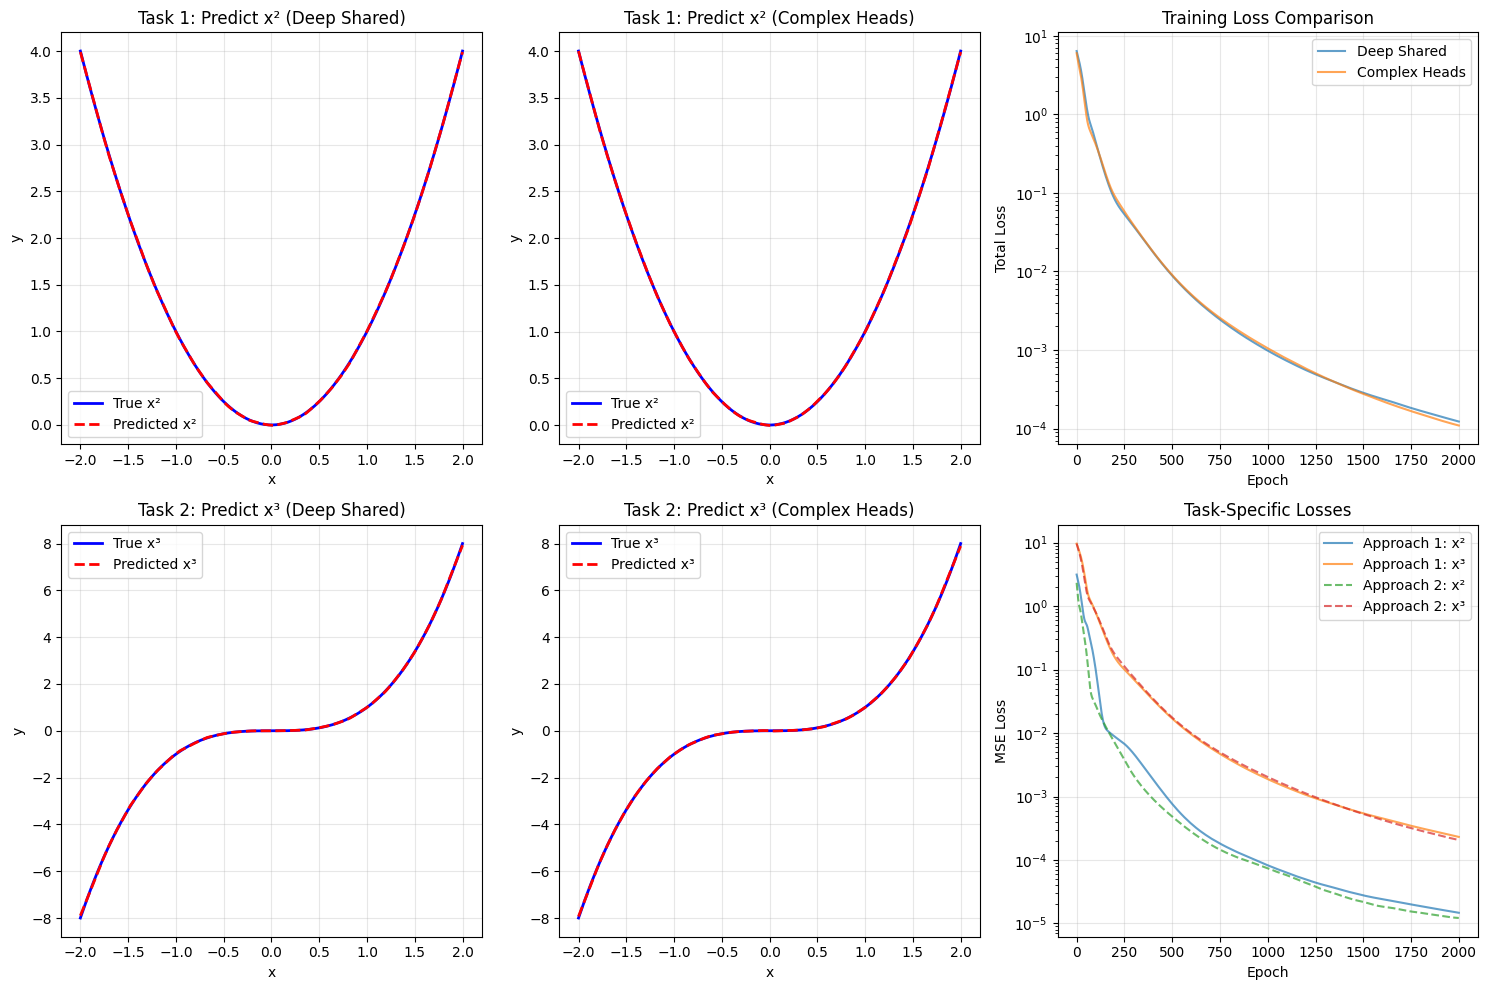


FINAL PERFORMANCE COMPARISON

Approach 1 (Deep Shared + Simple Heads):
  Task 1 (x²) MSE: 0.000015
  Task 2 (x³) MSE: 0.000231
  Average MSE:     0.000123

Approach 2 (Shallow Shared + Complex Heads):
  Task 1 (x²) MSE: 0.000012
  Task 2 (x³) MSE: 0.000207
  Average MSE:     0.000109

KEY TAKEAWAYS

1. Both architectures have similar total depth (3 layers per path)
2. Deep Shared: More parameter sharing → better when tasks are related
3. Complex Heads: More task specialization → better when tasks differ
4. For x² and x³: Both work well since tasks share polynomial structure
5. The "right" approach depends on your specific tasks and data



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# ============================================================================
# APPROACH 1: Deep Shared Backbone + Simple Heads
# Philosophy: Heavy feature extraction in shared layers, lightweight heads
# ============================================================================
class XPowerMTL_DeepShared(nn.Module):
    """Deep shared backbone with simple task-specific heads"""
    def __init__(self, hidden_dim=64):
        super().__init__()

        # Deep shared backbone - learns complex representations of x
        self.shared = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Simple heads - just linear mappings from shared features
        self.head1 = nn.Linear(hidden_dim, 1)  # for x²
        self.head2 = nn.Linear(hidden_dim, 1)  # for x³

    def forward(self, x):
        shared_features = self.shared(x)
        y1_hat = self.head1(shared_features)
        y2_hat = self.head2(shared_features)
        return y1_hat, y2_hat


# ============================================================================
# APPROACH 2: Shallow Shared Backbone + Complex Heads
# Philosophy: Basic shared features, specialized task-specific processing
# ============================================================================
class XPowerMTL_ComplexHeads(nn.Module):
    """Shallow shared backbone with complex task-specific heads"""
    def __init__(self, hidden_dim=64):
        super().__init__()

        # Shallow shared backbone - basic feature extraction
        self.shared = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU()
        )

        # Complex heads - deeper task-specific processing
        self.head1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )  # for x²

        self.head2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )  # for x³

    def forward(self, x):
        shared_features = self.shared(x)
        y1_hat = self.head1(shared_features)
        y2_hat = self.head2(shared_features)
        return y1_hat, y2_hat


# ============================================================================
# Training Function (works for both architectures)
# ============================================================================
def train_model(model, x, y1, y2, epochs=2000, lr=1e-3, alpha=0.5, beta=0.5):
    """Train a multitask model"""
    mse = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = {'total': [], 'task1': [], 'task2': []}

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        y1_hat, y2_hat = model(x)

        loss1 = mse(y1_hat, y1)
        loss2 = mse(y2_hat, y2)

        # Weighted combination of losses
        loss = alpha * loss1 + beta * loss2

        loss.backward()
        optimizer.step()

        # Track losses
        loss_history['total'].append(loss.item())
        loss_history['task1'].append(loss1.item())
        loss_history['task2'].append(loss2.item())

        if epoch % 400 == 0:
            print(
                f"Epoch {epoch:4d} | Total={loss.item():.6f} | "
                f"x²={loss1.item():.6f} | x³={loss2.item():.6f}"
            )

    return loss_history


# ============================================================================
# Data Preparation
# ============================================================================
torch.manual_seed(42)

x = torch.linspace(-2, 2, 200).unsqueeze(1)  # shape (200, 1)
y1 = x ** 2                                   # x²
y2 = x ** 3                                   # x³


# ============================================================================
# Train Both Models
# ============================================================================
print("=" * 70)
print("APPROACH 1: Deep Shared Backbone + Simple Heads")
print("=" * 70)
model1 = XPowerMTL_DeepShared(hidden_dim=64)
history1 = train_model(model1, x, y1, y2, epochs=2000, alpha=0.5, beta=0.5)

print("\n" + "=" * 70)
print("APPROACH 2: Shallow Shared Backbone + Complex Heads")
print("=" * 70)
model2 = XPowerMTL_ComplexHeads(hidden_dim=64)
history2 = train_model(model2, x, y1, y2, epochs=2000, alpha=0.5, beta=0.5)


# ============================================================================
# Visualization
# ============================================================================
x_np = x.squeeze().numpy()
y1_np = y1.squeeze().numpy()
y2_np = y2.squeeze().numpy()

# Get predictions
model1.eval()
model2.eval()
with torch.no_grad():
    y1_pred1, y2_pred1 = model1(x)
    y1_pred2, y2_pred2 = model2(x)

y1_pred1_np = y1_pred1.squeeze().numpy()
y2_pred1_np = y2_pred1.squeeze().numpy()
y1_pred2_np = y1_pred2.squeeze().numpy()
y2_pred2_np = y2_pred2.squeeze().numpy()


# Create comprehensive comparison plots
fig = plt.figure(figsize=(15, 10))

# Task 1: x² predictions
plt.subplot(2, 3, 1)
plt.title("Task 1: Predict x² (Deep Shared)")
plt.plot(x_np, y1_np, 'b-', label='True x²', linewidth=2)
plt.plot(x_np, y1_pred1_np, 'r--', label='Predicted x²', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.title("Task 1: Predict x² (Complex Heads)")
plt.plot(x_np, y1_np, 'b-', label='True x²', linewidth=2)
plt.plot(x_np, y1_pred2_np, 'r--', label='Predicted x²', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)

# Task 2: x³ predictions
plt.subplot(2, 3, 4)
plt.title("Task 2: Predict x³ (Deep Shared)")
plt.plot(x_np, y2_np, 'b-', label='True x³', linewidth=2)
plt.plot(x_np, y2_pred1_np, 'r--', label='Predicted x³', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.title("Task 2: Predict x³ (Complex Heads)")
plt.plot(x_np, y2_np, 'b-', label='True x³', linewidth=2)
plt.plot(x_np, y2_pred2_np, 'r--', label='Predicted x³', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)

# Training loss comparison
plt.subplot(2, 3, 3)
plt.title("Training Loss Comparison")
plt.plot(history1['total'], label='Deep Shared', alpha=0.7)
plt.plot(history2['total'], label='Complex Heads', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Task-specific losses
plt.subplot(2, 3, 6)
plt.title("Task-Specific Losses")
plt.plot(history1['task1'], label='Approach 1: x²', linestyle='-', alpha=0.7)
plt.plot(history1['task2'], label='Approach 1: x³', linestyle='-', alpha=0.7)
plt.plot(history2['task1'], label='Approach 2: x²', linestyle='--', alpha=0.7)
plt.plot(history2['task2'], label='Approach 2: x³', linestyle='--', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()


# ============================================================================
# Final Performance Comparison
# ============================================================================
print("\n" + "=" * 70)
print("FINAL PERFORMANCE COMPARISON")
print("=" * 70)

with torch.no_grad():
    # Approach 1: Deep Shared
    y1_pred1, y2_pred1 = model1(x)
    mse1_task1 = nn.MSELoss()(y1_pred1, y1).item()
    mse1_task2 = nn.MSELoss()(y2_pred1, y2).item()

    # Approach 2: Complex Heads
    y1_pred2, y2_pred2 = model2(x)
    mse2_task1 = nn.MSELoss()(y1_pred2, y1).item()
    mse2_task2 = nn.MSELoss()(y2_pred2, y2).item()

print(f"\nApproach 1 (Deep Shared + Simple Heads):")
print(f"  Task 1 (x²) MSE: {mse1_task1:.6f}")
print(f"  Task 2 (x³) MSE: {mse1_task2:.6f}")
print(f"  Average MSE:     {(mse1_task1 + mse1_task2)/2:.6f}")

print(f"\nApproach 2 (Shallow Shared + Complex Heads):")
print(f"  Task 1 (x²) MSE: {mse2_task1:.6f}")
print(f"  Task 2 (x³) MSE: {mse2_task2:.6f}")
print(f"  Average MSE:     {(mse2_task1 + mse2_task2)/2:.6f}")

print("\n" + "=" * 70)
print("KEY TAKEAWAYS")
print("=" * 70)
print("""
1. Both architectures have similar total depth (3 layers per path)
2. Deep Shared: More parameter sharing → better when tasks are related
3. Complex Heads: More task specialization → better when tasks differ
4. For x² and x³: Both work well since tasks share polynomial structure
5. The "right" approach depends on your specific tasks and data
""")